In [58]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
def periodic_cond(pos,dim,N,bound):
    
    for x in range(N):        
        for y in range(3):
            if bound[y] == 1:
                if pos.iloc[x,y] > dim[y]:
                    pos.iloc[x,y] = -(box[y]) + pos.iloc[x,y]
                elif pos.iloc[x,y] < 0:
                    pos.iloc[x,y] = (box[y]) + pos.iloc[x,y]
                else:
                    pos.iloc[x,y] = pos.iloc[x,y]
            else:
                pos.iloc[x,y] = pos.iloc[x,y]
    return pos

In [60]:
def cutoff():
    U    = []
    X_np = np.arange(0.001, 10, 0.001)
    X    = list(X_np)
    F    = []
    for x in X:
        dist2   = x*x
        dist6   = dist2**3
        dist12  = dist6**2
        dist13  = dist12*x
        dist7   = dist6*x
    
        u  = 4*lj_e*(lj_s12/dist12 - lj_s6/dist6)                            # Potential energy calculation
        f  = 4*lj_e*(((12 * lj_s12) / dist13) - ((6 * lj_s6) / dist7))       # Force calculation 
        
        U.append(u)
        F.append(f)
        
    min_index = U.index(min(U))
    print("Minima of interatomic potential with He-He:", U[min_index])
    print("Equilibrium interatomic distance of He-He:", X[min_index])
    
    PC = pd.DataFrame(list(zip(X,U,F)),
                      columns =['Int_dist','E_Pot','Force'])
    coords = PC.to_numpy()
    np.savetxt('LJ_Curve.out', coords)
    
    fig, ax = plt.subplots()
    ax.plot(X[min_index - 800 : min_index + 500] , U[min_index - 800 : min_index + 500],label = "E_pot")
    ax.plot(X[min_index - 800 : min_index + 500] , F[min_index - 800 : min_index + 500],label = "Force")


    ax.set(xlabel='Interatomic_Distance(r)', ylabel='Force(F) & E_pot(U)',
           title='Lennard-jones potential curve')
    ax.legend()
    
    fig.savefig("test.png")
    plt.show()
    
    return X[min_index]

In [61]:
def Skin(pos,N,cutoff):
    r = cutoff + 4.0
    neigh = []
    for x in range(N):
        nh = []
        for y in range(x+1,N):
            if pos.iloc[x,0]-pos.iloc[y,0]<=r and pos.iloc[x,1]-pos.iloc[y,1]<=r and pos.iloc[x,2]-pos.iloc[y,2]<=r:
                nh.append(y)
        for y in range(x-1,0,-1):
            if pos.iloc[x,0]-pos.iloc[y,0]<=r and pos.iloc[x,1]-pos.iloc[y,1]<=r and pos.iloc[x,2]-pos.iloc[y,2]<=r:
                nh.append(y)
        neigh.append(nh)
    return neigh

In [62]:
def Neighbours(pos,skin,N,cutoff):
    r = cutoff + 2.0
    neighh = []
    for x in range(N):
        nhh = []
        for y in range(len(skin[x])):
            if pos.iloc[x,0]-pos.iloc[skin[x][y],0]<=r and pos.iloc[x,1]-pos.iloc[skin[x][y],1]<=r and pos.iloc[x,2]-pos.iloc[skin[x][y],2]<=r:
                nhh.append(skin[x][y])
        neighh.append(nhh)
    return neighh

In [63]:
def lennard_jones(pos,neigh,N):
    distt2 = []
    for x in range(N):
        dist = []
        for y in range(len(neigh[x])):
            distt = pos.iloc[x,0]*pos.iloc[neigh[x][y],0] + pos.iloc[x,1]*pos.iloc[neigh[x][y],1]+pos.iloc[x,2]*pos.iloc[neigh[x][y],2]
            #distt = distt**2
            #distt = math.sqrt(distt)
            dist.append(distt)
        distt2.append(dist)    
#    print(distt2)
    U = []
    F = []
    for i in range(N):
        UU = []
        FF = []
        for j in range(len(distt2[i])): 
            dist6   = distt2[i][j]**3
            dist12  = dist6**2
            dist13  = dist12*math.sqrt(distt2[i][j])
            dist7   = dist6*math.sqrt(distt2[i][j])
    
            u  = 4*lj_e*(lj_s12/dist12 - lj_s6/dist6)                            # Potential energy calculation
            f  = 4*lj_e*(((12 * lj_s12) / dist13) - ((6 * lj_s6) / dist7))       # Force calculation
            
            UU.append(u)
            FF.append(f)
        if len(UU) > 0:    
            U_avg = sum(UU)/len(UU)
            #F_avg = sum(FF)/len(FF)
            UU    = []
            #FF    = []
            UU.append(U_avg)
            #FF.append(F_avg)
        U.append(UU)
        F.append(FF)
        
    return (U, F)

In [64]:
#Velocity verlet algorithm
def new_pos(X_old,V_old,F_old,m,t):                                    #Algorithm For new position
    X_new = X_old + (t)*V_old + ((t**2)*F_old)/(2*m)
    return(X_new)

def new_vel(F_old,F_new,V_old,t,m):                                    #Algorithm for new velocity
    V_new = (F_old + F_new)
    V_new = (V_new * t)/(2*m)
    V_new = V_old + V_new
    return(V_new)

In [65]:
def write_out(dataframe,name):
    xx = dataframe.to_numpy()
    np.savetxt(name, x)

In [66]:
#Parameters are provided for Helium(He) atom.

box         = (50.0,50.0,50.0)   # Dimensions             [In Angstrom]
bound       = (1,1,1)
N_atom      = 50                  # No of atoms
N_step      = 500                 # No of Steps
N_write     = 100                 # Steps at which co-ordinate to be saved
Delta       = 10.0               # Time steps             [In ferrosecond]

temp        = 200.0;              # Temperature            [In Kelvin]

lj_s        = 2.5238;            # Lennard_jones_sigma    [In Angstrom]
lj_e        = 0.01962;           # Lennard_jones_epsilon  [In Kcal/mol]
mass        = 4.002602;          # Mass of atom           [In amu] 
bltz_const  = 0.001987191;       # Boltzmann constant     [In Kcal/mol/K]

tf          = 1**(-15)           # Time factor            [Convert second to ferrosecond]

In [67]:
#Pre-defined factors

dt          = Delta/tf
dt2         = dt * dt

v0          = math.sqrt(bltz_const * temp/mass)

lj_s6       = lj_s**6
lj_s12      = lj_s**12

In [68]:
x_coords = []
y_coords = []
z_coords = []

for c in range(N_atom):
    x = random.random()
    y = random.random() 
    z = random.random() 
    pos = [x,y,z]
    
    for i in range(3):
        if pos[i] > (box[i]/100):
            pos[i] -= (box[i]/100)
            
        else:
            pos[i] = pos[i]
        pos[i] = round(pos[i] * (10**5)) / 1000
        
    x_coords.append(pos[0])
    y_coords.append(pos[1])
    z_coords.append(pos[2])
    
df = pd.DataFrame(list(zip(x_coords,y_coords,z_coords)),
                  columns =['x_coords','y_coords','z_coords'])
coords = df.to_numpy()
np.savetxt('Initial_conf.out', coords)
#dff = df.copy()

In [69]:
#Initial velocity and momentum
vel0 = []
momentum = [0.0,0.0,0.0]
for k in range(N_atom):
    vel0.append([random.gauss(0,v0), random.gauss(0,v0), random.gauss(0,v0)])
    for kk in range(3):
        momentum[kk] += mass*vel0[k][kk] 

#Removal of residual momentum        
residual_mom = []        
for c in range(3):
    residual_mom.append(momentum[c]/N_atom)
for i in range(N_atom):
    for c in range(3):
        vel0[i][c] -= residual_mom[c]/mass

force = []
for i in range(N_atom):
    force.append([0.0, 0.0, 0.0])

Minima of interatomic potential with He-He: -0.019619998506585003
Equilibrium interatomic distance of He-He: 2.8329999999999997


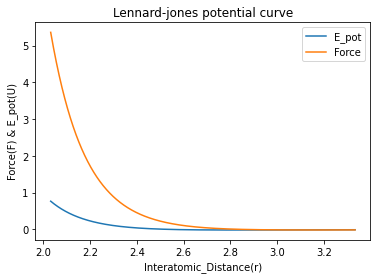

In [70]:
co = cutoff()

In [71]:
# MAIN SIMULATION LOOP
for step in range(N_step + 1):
    
    xx_coords = []
    yy_coords = []
    zz_coords = []
    
    # Zero the forces
    for i in range(N_atom):
        for c in range(3):
            force[i][c] = 0.0
           
    # Calculate interaction forces
    if step%10 == 0:
        sk = Skin(df,N_atom,co)
    
    neig     = Neighbours(df,sk,N_atom,co)
    
    U_E, I_F =lennard_jones(df,neig,N_atom)
    
    ener_pot = 0.0
    for kk in range(N_atom):
        if len(U_E[kk]) > 0:
            ener_pot += U_E[kk][0]
    
    force_new = force
    for i in range(N_atom):
        if len(I_F[i]) > 0:
            for j in range(len(I_F[i])):
                for k in range(3):
                    force_new[i][k]          += I_F[i][j]  
                    force_new[neig[i][j]][k] -= I_F[i][j]
    force = force_new
    
    pos_new = []
    vel_new = []
    for i in range(N_atom):
        p = []
        v = []
        for j in range(3):
            ijk = new_pos(df.iloc[i,j],vel0[i][j],force_new[i][j],mass,dt)
            vvv = new_vel(force[i][j],force_new[i][j],vel0[i][j],dt,mass)
            p.append(ijk)
            v.append(vvv)
        vel_new.append(v)
        pos_new.append(p)
            
        xx_coords.append(p[0])
        yy_coords.append(p[1])
        zz_coords.append(p[2])
        
    # Calculate the kinetic energy
    ener_kin = 0.0
    for i in range(N_atom):
        ener_kin += 0.5*mass*(vel_new[i][0]**2 + vel_new[i][1]**2 + vel_new[i][2]**2)
    ener_total = ener_pot + ener_kin
    mean_temp = 2.0*ener_kin/(3*bltz_const*(N_atom-1))
    print("step %9d  ener_total %9.4f  ener_pot %9.4f  ener_kin %9.4f mean_temp %8.3f" % (step,ener_total,ener_pot,ener_kin,mean_temp))
    
    n_df = pd.DataFrame(list(zip(xx_coords,yy_coords,zz_coords)),
                    columns =['xx_coords','yy_coords','zz_coords'])
    periodic_cond(n_df,box,N_atom,bound)
    df = n_df
    vel0 = vel_new
    if step%N_write == 0:
        crds  = df.to_numpy()
        name  = str(step) + '.out'
        np.savetxt(name, crds)

step         0  ener_total   35.7296  ener_pot   -0.0000  ener_kin   35.7296 mean_temp  244.625
step         1  ener_total   35.7296  ener_pot   -0.0000  ener_kin   35.7296 mean_temp  244.625
step         2  ener_total   35.7296  ener_pot   -0.0000  ener_kin   35.7296 mean_temp  244.625
step         3  ener_total   35.7296  ener_pot   -0.0000  ener_kin   35.7296 mean_temp  244.625
step         4  ener_total   35.7296  ener_pot   -0.0000  ener_kin   35.7296 mean_temp  244.625
step         5  ener_total   35.7296  ener_pot   -0.0000  ener_kin   35.7296 mean_temp  244.625
step         6  ener_total   35.7299  ener_pot   -0.0000  ener_kin   35.7299 mean_temp  244.627
step         7  ener_total   35.7299  ener_pot   -0.0000  ener_kin   35.7299 mean_temp  244.627
step         8  ener_total   35.7299  ener_pot   -0.0000  ener_kin   35.7299 mean_temp  244.627
step         9  ener_total   35.7299  ener_pot   -0.0000  ener_kin   35.7299 mean_temp  244.627
step        10  ener_total   35.7299  en

step        89  ener_total   35.7618  ener_pot   -0.0000  ener_kin   35.7618 mean_temp  244.846
step        90  ener_total   35.7618  ener_pot   -0.0000  ener_kin   35.7618 mean_temp  244.846
step        91  ener_total   35.7618  ener_pot   -0.0000  ener_kin   35.7618 mean_temp  244.846
step        92  ener_total   35.7617  ener_pot   -0.0000  ener_kin   35.7617 mean_temp  244.845
step        93  ener_total   35.7616  ener_pot   -0.0000  ener_kin   35.7616 mean_temp  244.845
step        94  ener_total   35.7617  ener_pot   -0.0000  ener_kin   35.7617 mean_temp  244.845
step        95  ener_total   35.7617  ener_pot   -0.0000  ener_kin   35.7617 mean_temp  244.845
step        96  ener_total   35.7617  ener_pot   -0.0000  ener_kin   35.7617 mean_temp  244.845
step        97  ener_total   35.7617  ener_pot   -0.0000  ener_kin   35.7617 mean_temp  244.845
step        98  ener_total   35.7617  ener_pot   -0.0000  ener_kin   35.7617 mean_temp  244.845
step        99  ener_total   35.7616  en

step       178  ener_total   35.7536  ener_pot   -0.0000  ener_kin   35.7536 mean_temp  244.789
step       179  ener_total   35.7536  ener_pot   -0.0000  ener_kin   35.7536 mean_temp  244.789
step       180  ener_total   35.7521  ener_pot   -0.0000  ener_kin   35.7521 mean_temp  244.779
step       181  ener_total   35.7517  ener_pot   -0.0000  ener_kin   35.7517 mean_temp  244.776
step       182  ener_total   35.7519  ener_pot   -0.0000  ener_kin   35.7519 mean_temp  244.778
step       183  ener_total   35.7519  ener_pot   -0.0000  ener_kin   35.7519 mean_temp  244.778
step       184  ener_total   35.7519  ener_pot   -0.0000  ener_kin   35.7519 mean_temp  244.778
step       185  ener_total   35.7519  ener_pot   -0.0000  ener_kin   35.7519 mean_temp  244.778
step       186  ener_total   35.7519  ener_pot   -0.0000  ener_kin   35.7519 mean_temp  244.778
step       187  ener_total   35.7520  ener_pot   -0.0000  ener_kin   35.7520 mean_temp  244.779
step       188  ener_total   35.7520  en

step       265  ener_total   35.7432  ener_pot   -0.0000  ener_kin   35.7432 mean_temp  244.719
step       266  ener_total   35.7432  ener_pot   -0.0000  ener_kin   35.7432 mean_temp  244.719
step       267  ener_total   35.7432  ener_pot   -0.0000  ener_kin   35.7432 mean_temp  244.718
step       268  ener_total   35.7432  ener_pot   -0.0000  ener_kin   35.7432 mean_temp  244.718
step       269  ener_total   35.7328  ener_pot   -0.0001  ener_kin   35.7328 mean_temp  244.647
step       270  ener_total   35.7327  ener_pot   -0.0000  ener_kin   35.7327 mean_temp  244.646
step       271  ener_total   35.7326  ener_pot   -0.0000  ener_kin   35.7326 mean_temp  244.646
step       272  ener_total   35.7326  ener_pot   -0.0000  ener_kin   35.7326 mean_temp  244.646
step       273  ener_total   35.7326  ener_pot   -0.0000  ener_kin   35.7326 mean_temp  244.646
step       274  ener_total   35.7326  ener_pot   -0.0000  ener_kin   35.7326 mean_temp  244.646
step       275  ener_total   35.7326  en

step       351  ener_total   35.6969  ener_pot   -0.0000  ener_kin   35.6969 mean_temp  244.402
step       352  ener_total   35.6969  ener_pot   -0.0000  ener_kin   35.6969 mean_temp  244.402
step       353  ener_total   35.6969  ener_pot   -0.0000  ener_kin   35.6969 mean_temp  244.402
step       354  ener_total   35.6969  ener_pot   -0.0000  ener_kin   35.6969 mean_temp  244.401
step       355  ener_total   35.6969  ener_pot   -0.0000  ener_kin   35.6969 mean_temp  244.401
step       356  ener_total   35.6969  ener_pot   -0.0000  ener_kin   35.6969 mean_temp  244.401
step       357  ener_total   35.6969  ener_pot   -0.0000  ener_kin   35.6969 mean_temp  244.401
step       358  ener_total   35.6969  ener_pot   -0.0000  ener_kin   35.6969 mean_temp  244.402
step       359  ener_total   35.6972  ener_pot   -0.0000  ener_kin   35.6972 mean_temp  244.404
step       360  ener_total   35.7364  ener_pot   -0.0002  ener_kin   35.7366 mean_temp  244.673
step       361  ener_total   35.7366  en

step       438  ener_total   35.7363  ener_pot   -0.0000  ener_kin   35.7363 mean_temp  244.671
step       439  ener_total   35.7363  ener_pot   -0.0000  ener_kin   35.7363 mean_temp  244.671
step       440  ener_total   35.7363  ener_pot   -0.0000  ener_kin   35.7363 mean_temp  244.671
step       441  ener_total   35.7363  ener_pot   -0.0000  ener_kin   35.7363 mean_temp  244.671
step       442  ener_total   35.7364  ener_pot   -0.0000  ener_kin   35.7364 mean_temp  244.672
step       443  ener_total   35.7364  ener_pot   -0.0000  ener_kin   35.7364 mean_temp  244.672
step       444  ener_total   35.7364  ener_pot   -0.0000  ener_kin   35.7364 mean_temp  244.672
step       445  ener_total   35.7364  ener_pot   -0.0000  ener_kin   35.7364 mean_temp  244.672
step       446  ener_total   35.7361  ener_pot   -0.0000  ener_kin   35.7361 mean_temp  244.670
step       447  ener_total   35.7361  ener_pot   -0.0000  ener_kin   35.7361 mean_temp  244.669
step       448  ener_total   35.7361  en